# Tuned Logistic Regression Model 2

Running a logistic regression model with selected features and polynomial features.

__Imports__

In [1]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

style.use('fivethirtyeight')
# import jupyterthemes as jt
# context = jt.jtplot.set_context('paper')
# jt.jtplot.set_style(context, 'monokai', ticks=True, spines=True)
# jt.stylefx.style_layout('nb_style', theme='monokai',
#                         toolbar=True, nbname=True, cellwidth='1000')
# jt.stylefx.set_nb_theme('monokai')


## Read in the data and instantiate logistic regression model

In [3]:
df = pd.read_csv("../data/device_failure_data_scientist.csv")
df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0


In [4]:
# list of features to use base off coeffs.
feat = ['attribute2', 'attribute4', 'attribute7',
        'attribute8'] 

features = df[feat]
labels = df['failure']

In [25]:
X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    shuffle=False)

In [26]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [27]:
lr = LogisticRegression(penalty='elasticnet',
                        C=0.0001,
                        max_iter=500,
                        class_weight='balanced',
                        solver='saga',
                        l1_ratio=0.65,
                        random_state=42)

lr.fit(X_train_ss, y_train)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.65,
                   max_iter=500, multi_class='warn', n_jobs=None,
                   penalty='elasticnet', random_state=42, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

## LogReg metrics

In [28]:
lr.score(X_train_ss, y_train)

0.9840955338973975

In [29]:
lr.score(X_test_ss, y_test)
# accuracy = 0.998

0.9750032129546331

In [30]:
np.exp(
    lr.coef_
)  # exponentiate because the initial coefficents are the log of the odds.

array([[1.10064983, 1.18632707, 1.24530014, 1.24530014]])

**Coefficients (odds of failing):**

- `attribute2` = $1.39$
- `attribute4` = $1.87$
- `attribute7` = $1.71$
- `attribute8` = $1.71$


In [31]:
# Generate predictions.
preds = lr.predict(X_test_ss)

# Generate confusion matrix.
confusion_matrix(y_test, preds)

array([[30335,   763],
       [   15,    11]], dtype=int64)

In [33]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Specificity and Sensitivity

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec, 4)}')
print(f'Sensitivity: {round(sens, 4)}')

Specificity: 0.9755
Sensitivity: 0.4231


In [34]:
pred_proba = [i[1] for i in lr.predict_proba(X_test_ss)]

pred_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_proba})

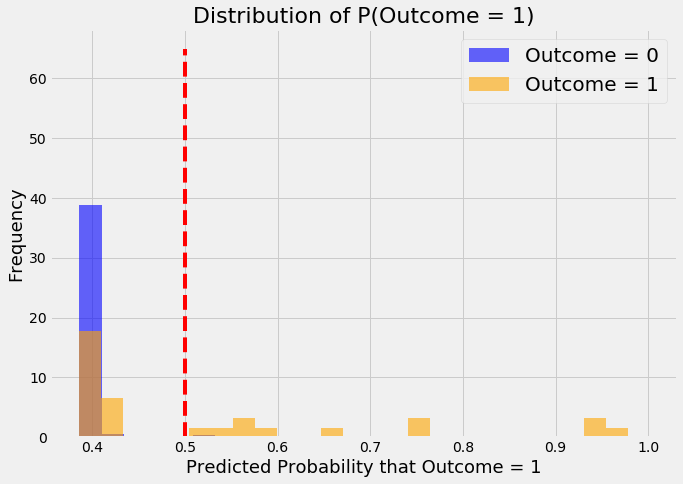

In [35]:
plt.figure(figsize=(10, 7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha=0.6,
         label='Outcome = 0',
         density=True)

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha=0.6,
         label='Outcome = 1',
         density=True)

# Threshold
plt.vlines(x=0.5, ymin=0, ymax=65, color='r', linestyle='--')


plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.legend(fontsize=20)

### ROC AUC 

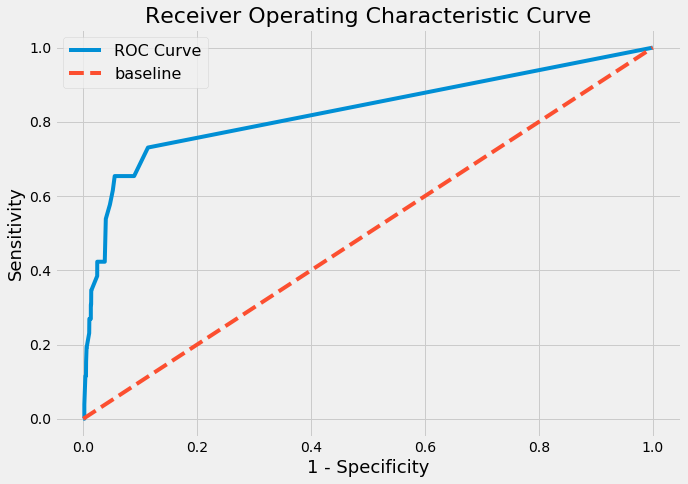

In [36]:
plt.figure(figsize=(10, 7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity.
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1)
                       & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1)
                        & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)


# Define function to calculate 1 - specificity.
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0)
                       & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0)
                        & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))


# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [
    TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]
fpr_values = [
    FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]

# Plot ROC curve.
plt.plot(
    fpr_values,  # False Positive Rate on X-axis
    tpr_values,  # True Positive Rate on Y-axis
    label='ROC Curve')

# Plot baseline.
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')


plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
plt.legend(fontsize=16)

In [37]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.8449102588838262

$$AUC = 0.845$$

## Results

Dropping all the features which coefficients went to zero returned the same results. The model only has 4 features so to improve performance new features will need to be added, especially since the number of observations is in the 100k's.  

In [16]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     31098
           1       0.01      0.42      0.03        26

    accuracy                           0.98     31124
   macro avg       0.51      0.70      0.51     31124
weighted avg       1.00      0.98      0.99     31124



# Polynomial Features

Since there isn't much context or info on the attributes, it's difficult to come up with any interaction terms which is why I decided to use polynomial features for feature engineering. 

In [6]:
df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0


In [7]:
# feats = df.drop(columns=['date', 'device', 'failure'])

In [337]:
X = features
y = df['failure']

In [338]:
poly = PolynomialFeatures()

X_poly = poly.fit_transform(X)

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X_poly,
                                                    y,
                                                    random_state=42,
                                                    shuffle=False)

In [340]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [341]:
lr = LogisticRegression(penalty='l2',
                        C=.0001,
                        max_iter=100,
                        class_weight='balanced',
                        solver='sag',
                        random_state=42,
                        n_jobs=-1)

lr.fit(X_train_ss, y_train)

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=42, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [342]:
lr.score(X_train_ss, y_train)

0.9793509692620757

In [343]:
lr.score(X_test_ss, y_test)

0.9748104356766483

In [344]:
np.exp(lr.coef_)

array([[1.        , 1.26729146, 1.38872014, 1.40808821, 1.40808821,
        0.92928704, 0.98361999, 0.9566981 , 0.9566981 , 0.94458577,
        1.00831817, 1.00831817, 0.98739125, 0.98739125, 0.98739125]])

There isn't anything wildly surprising or different about the coeffs or the model accuracy.  I used l2 regularization to not drive coefficients to zero to see if all the features could contribute something.

In [345]:
# Generate predictions.
preds = lr.predict(X_test_ss)

# Generate confusion matrix.
confusion_matrix(
    y_test,  
    preds) 

array([[30329,   769],
       [   15,    11]], dtype=int64)

In [346]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Specificity and Sensitivity

spec = tn / (tn + fp)
sens = tp / (tp + fn)

print(f'Specificity: {round(spec, 4)}')
print(f'Sensitivity: {round(sens, 4)}')

Specificity: 0.9753
Sensitivity: 0.4231


In [347]:
pred_proba = [i[1] for i in lr.predict_proba(X_test_ss)]
pred_df = pd.DataFrame({'true_values': y_test, 'pred_probs': pred_proba})

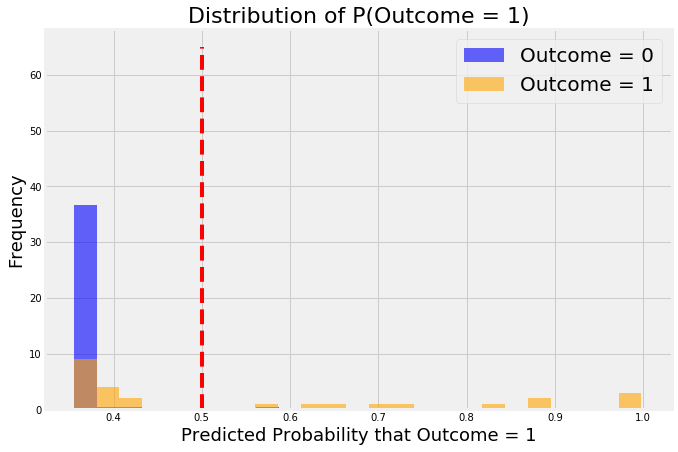

In [348]:
plt.figure(figsize=(10, 7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha=0.6,
         label='Outcome = 0',
         density=True)

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha=0.6,
         label='Outcome = 1')

# Threshold
plt.vlines(x=0.5, ymin=0, ymax=65, color='r', linestyle='--')


plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
plt.legend(fontsize=20)

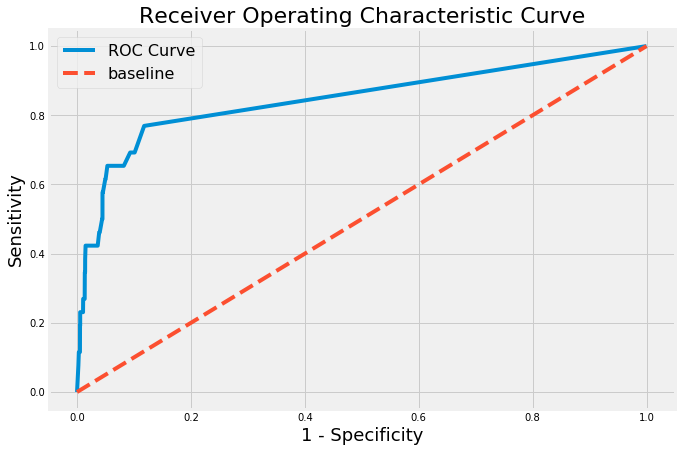

In [349]:
plt.figure(figsize=(10, 7))

# threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity.
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1)
                       & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1)
                        & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)


# Define function to calculate 1 - specificity. 
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0)
                       & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0)
                        & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))


# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [
    TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]
fpr_values = [
    FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds
]

# Plot ROC curve.
plt.plot(
    fpr_values,  # False Positive Rate on X-axis
    tpr_values,  # True Positive Rate on Y-axis
    label='ROC Curve')

# Plot baseline. 
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')


plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
plt.legend(fontsize=16)

In [350]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.8451242226806571

## Results

There really wasn't any improvement in the model's ability to differentiate between the two classes after feature engineering.  After 3 different approaches to the logistic regression model a more complex model is my next approach.

In [351]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     31098
           1       0.01      0.42      0.03        26

    accuracy                           0.97     31124
   macro avg       0.51      0.70      0.51     31124
weighted avg       1.00      0.97      0.99     31124

